In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pandas as pd

from sklearn.model_selection import train_test_split


from tqdm.notebook import tqdm
tqdm.pandas()


from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

# ------------
CUDA_LAUNCH_BLOCKING="1"
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [3]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


# Tokenizer
___

In [5]:
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_truncation(max_length=512)
tokenizer.enable_padding(direction='left',length=512)
trainer = BpeTrainer(vocab_size=20000,min_frequency=2,special_tokens=['[PAD]','[UNK]'])

In [6]:
tokenizer.train_from_iterator(df['full_text'], trainer)

In [7]:
len(df['full_text'][34].split())

1136

# Dataset
___

In [8]:
class EssayDataset:
    def __init__(self, df, tokenizer, test=False):
        self.test = test
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.texts = list(df['full_text'].values)
        if self.test is False:
            self.labels = df.loc[:,self.classes].values
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        text = self.tokenizer.encode(text).ids
        text = torch.tensor(text, dtype=torch.long)
        if self.test is False:
            label = self.labels[idx,:] / 5.
            label = torch.tensor(label, dtype=torch.float32)
            return text, label
        return text

In [9]:
sample_ds = EssayDataset(df,tokenizer)

In [10]:
print(len(df['full_text'][0].split()))
encoded = tokenizer.encode(df['full_text'][0]).ids
print(len(encoded))
print(encoded)
tokenizer.decode(encoded)

261
512
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 238, 119, 192, 234, 746, 263, 559, 101, 283, 13, 158, 127, 1218, 142, 99, 376, 110, 201, 309, 743, 94, 95, 1495, 99, 5329, 110, 136, 273, 3275, 15, 727, 486, 339, 728, 225, 158, 101, 273, 912, 127, 8, 140, 107, 682, 205, 1073, 15, 127, 196, 107, 1465, 101, 283, 15, 240, 3282, 660, 134, 176, 112, 654, 613, 15

"I think that students would benefit from learning at home , because they wont have to change and get up early in the morning to shower and do there hair . taking only classes helps them because at there house they ' ll be pay more attention . they will be comfortable at home . The hardest part of school is getting ready . you wake up go brush your teeth and go to your closet and look at your cloths . after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain . Then you ' ll have to change . with the online classes you can wear anything and stay home and you wont need to stress about what to wear . most students usually take show ers before school . they either take it before they sleep or when they wake up . some students do both to smell good . that causes them do miss the bus and effects on there lesson time cause they come late to school . when u have online classes u wont need to miss lessons cause you can get everything se

In [11]:
class RNNModel(pl.LightningModule):
    def __init__(self, config):
        super(RNNModel, self).__init__()
        self.save_hyperparameters()
        self.config = config
        self.vocab_size = self.config['vocab']
        self.embed_dim = self.config['embed_dim']
        self.hidden_dim = self.config['hidden_dim']
        self.seq_len = self.config['seq_len']
        self.n_layers = self.config['n_layers']
        self.output_dim = self.config['output_dim']
        
        self.lr = config['lr']
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers = self.n_layers,
                            batch_first = True
                           )
        
        self.drop = nn.Dropout(0.3)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.test_preds = []
        

    def forward(self, x):
        x = self.embedding(x)
        x, (h,c) = self.lstm(x)
        x = self.drop(h[-1])
        x = self.linear(x)
        return x
    
    def loss_fn(self, outputs, targets):
        # MCRMSE: https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/348985
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    

    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=20,eta_min=1e-6)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        outputs = self(x)
        
        loss = self.loss_fn(outputs, y)

        self.log('train_loss', loss.item(), on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x,y = batch
        
        outputs = self(x)
        
        loss = self.loss_fn(outputs, y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        
    def test_step(self, batch, batch_idx):
        sample = batch
        preds = self(sample) * 5.
        self.test_preds.append(preds.detach().cpu())
        
    def get_predictions(self):
        return torch.cat(self.test_preds).numpy()


In [12]:
score_cols = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
df['total_score'] = df.loc[:,score_cols].sum(axis=1)

In [13]:
config = {
    'vocab': tokenizer.get_vocab_size(),
    'embed_dim': 15,
    'hidden_dim': 32,
    'seq_len': 512,
    'n_layers': 4,
    'output_dim': len(score_cols),
    'lr': 3e-4,
    'epochs': 25,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 8,
    'seed': 1357,
    'model_name': 'lstm-embeddings'
}
print(config)

{'vocab': 17717, 'embed_dim': 15, 'hidden_dim': 32, 'seq_len': 512, 'n_layers': 4, 'output_dim': 6, 'lr': 0.0003, 'epochs': 25, 'device': 'cuda', 'batch_size': 8, 'seed': 1357, 'model_name': 'lstm-embeddings'}


In [14]:
def prepare_datasets(df,test_size=0.2):
    train_df, val_df = train_test_split(df, 
                                         test_size=test_size, 
                                         shuffle=True,
                                         random_state = config['seed']
                                        )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_ds = EssayDataset(train_df, tokenizer)
    val_ds = EssayDataset(val_df, tokenizer)

    train_loader = torch.utils.data.DataLoader(train_ds,batch_size=config['batch_size'],shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_ds,batch_size=config['batch_size'])
    
    return train_loader, val_loader

In [15]:
train_loader, val_loader = prepare_datasets(df)
len(train_loader), len(val_loader)

(391, 98)

In [16]:
test_ds = EssayDataset(test_df,tokenizer,test=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [17]:
_x,_y = next(iter(train_loader))
_x.shape, _y.shape

(torch.Size([8, 512]), torch.Size([8, 6]))

In [18]:
model = RNNModel(config)

In [19]:
trainer = pl.Trainer(accelerator='gpu', 
                     callbacks=[
                         EarlyStopping(monitor="val_loss", 
                                       mode="min",
                                       patience=5,
                                      )
                     ],
                     max_epochs = config['epochs']
                    )

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

0.017378008287493765


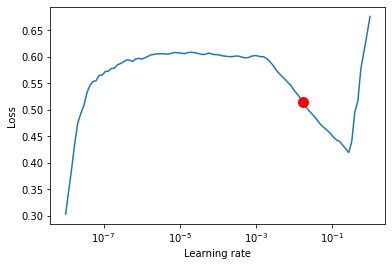

In [20]:
lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

In [21]:
model.hparams.lr = new_lr

In [22]:
model.hparams

"config": {'vocab': 17717, 'embed_dim': 15, 'hidden_dim': 32, 'seq_len': 512, 'n_layers': 4, 'output_dim': 6, 'lr': 0.0003, 'epochs': 25, 'device': 'cuda', 'batch_size': 8, 'seed': 1357, 'model_name': 'lstm-embeddings'}
"lr":     0.017378008287493765

In [23]:
trainer.fit(model, train_loader, val_loader)
metrics = trainer.logged_metrics

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [24]:
logs = {
    'train_loss': metrics['train_loss_epoch'].item(),
    'val_loss': metrics['val_loss'].item()
}

In [25]:
logs

{'train_loss': 0.12483596801757812, 'val_loss': 0.12011288106441498}

In [26]:
trainer.test(model,test_loader)

Testing: 0it [00:00, ?it/s]

[{}]

In [27]:
p = model.get_predictions()

In [28]:
p.shape

(3, 6)

In [29]:
submission = pd.DataFrame({'text_id':test_df['text_id']})
submission[score_cols] = p

In [30]:
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.151570,3.051540,3.257386,3.135021,3.050728,3.092027
1,000BAD50D026,3.505343,3.313100,3.593311,3.445598,3.383889,3.420348
2,00367BB2546B,3.043043,2.967445,3.153773,3.036996,2.950093,2.987782


In [31]:
submission.to_csv('submission.csv',index=False)